In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('/home/jlaura/themisra'))

In [21]:
from themisra.themis_ra import process_image
from themisra.processing.processing import optimize_pixel
from plio.io.io_gdal import array_to_raster, GeoDataset

## Configuration
Here we copy/paste in one of the example configuration files and make a few small changes:

1. change true to True and false to False
2. Define a custom working_dir and then set the `outpath` and `workingdir` to our custom output

In [3]:
working_dir = "/scratch/jlaura/themis_temp"

job = {"tesatm": True,                                                                
    "outpath": working_dir,                           
    "images": "/pds_san/PDS_Archive/Mars_Odyssey/THEMIS/USA_NASA_PDS_ODTSDP_100XX/ODTSDP_10006/data/odtir1_0006/i065xxrdr/I06520011RDR.QUB",
    "processing_pipeline": "themis_davinci",                                    
    "force": True,                                                              
    "deplaid": False,                                                           
    "workingdir": working_dir,                       
    "uddw": True,                                                               
    "projection": {"name": "None"},                                             
    "rtilt": True,                                                              
    "name": "THEMIS",                                                           
    "outputformat": ["GTiff"],                                                  
    "ancillarydata": {"emissivity": 1.0,                                        
        "slope": "/scratch/rfergason/ti_algorithm/input_data/MOLA_HRSC/Mars_MOLA_blend200ppx_HRSC_LatScaledSlope_clon0dd_200mpp.cub",
        "dustopacity": "montone",                                               
        "albedo": "/scratch/jlaura/KRC/basemaps/TES_global_Albedo_Christensen_2001.tif",
        "elevation": "/scratch/rfergason/ti_algorithm/input_final/elevation_MOLA_HRSC/Mars_MOLA_blend200ppx_HRSC_DEM_clon0dd_200mpp_lzw.tif",
        "slopeazimuth": "/scratch/rfergason/ti_algorithm/input_data/MOLA_HRSC/Mars_MOLA_blend200ppx_HRSC_Aspect_clon0dd_200mpp.cub"},
    "bands": [9, 10],                                                           
    "lat_extent": [18.44, 18.46],                                               
    "lon_extent": [77.39, 77.46],                                               
"lookuptables": "/scratch/jlaura/krc_lookup344.h5"}  

## Pre- and Post-Processing

This next cell will require a bit of time to run (the `[*]` (star) indicated that the call is running).  The process_image gets all of the ancillary data collected, projected, processed, and clipped so that the algorithm can be run.  All of the outputs are being written into the `workingdir/tmp*` defined above, where `tmp*` is going to be a uniquely generated folder (for example, `tmpgezxlkg0/`).  Once the processing is completed four arrays are returned.

1. `band_a` is the lower band, e.g., band 3 if the image has band 3
2. `band_b` is the upper band, e.g., band 9 if the image has band 9
3. `rock_a` is the rock TI computed for `band_a`
4. `rock_b` is the rock TI computed for `band_b`

In [4]:
band_a, band_b, rock_a, rock_b = process_image(job, bands=[4,9])  # The data set that was requested for processing does not contain band 3...

Working dir created at /scratch/jlaura/themis_temp/tmpf84_7vaw
Preprocessing completed.
[18.44, 18.46] [77.39, 77.46]
Davinci processing completed.
Ancillary data collection completed.
/scratch/jlaura/themis_temp/tmpf84_7vaw/I06520011RDR_dvprocessed_temp_proj_cropped.cub
Bands 4 and 9 extracted.
Rock 4 and rock 9 computed.
Pre- & post-processing complete.


## Apply the optimization algorithm to each pixel
Now that the data has been returned, we can apply the optimization algorithm to each pixel.

The results array contains 5 dimensions (bands):
1. alpha
2. fines in band a
3. fines in band b
4. success boolean for the optimization
5. the number of iterations needed to converge to a solution

I walked out of the office while this ran....maybe 5 minutes?

In [11]:
# Create the results array
result = np.zeros((band_a.shape[0], band_a.shape[1], 5))
for i in range(band_a.shape[0]):
    for j in range(band_a.shape[1]):
        result[i,j,:] = optimize_pixel(band_a[i,j],band_b[i,j], rock_a[i,j], rock_b[i,j])

## Visualize the results in the notebook
To visualize the results within this notebook we can simply use the built in plotting functionality.

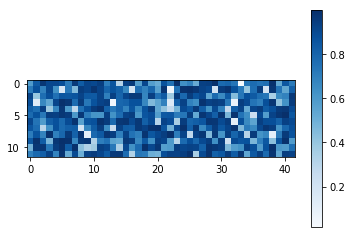

In [12]:
# Look at the alpha band (band 0)
imshow(result[:,:,0], cmap='Blues')
colorbar()

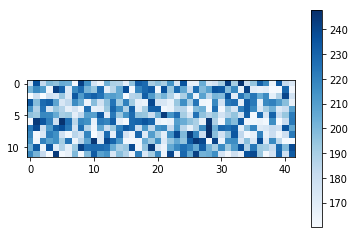

In [13]:
# Look at the fines 3 band (band 1)
imshow(result[:,:,1], cmap='Blues')
colorbar()

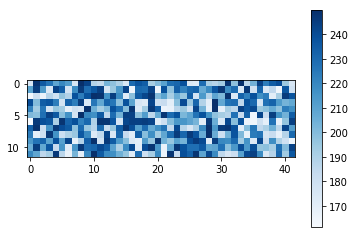

In [14]:
# Look at the fines 9 band (band 1)
imshow(result[:,:,2], cmap='Blues')
colorbar()

## Output the result array to a geotiff so that it can get loaded into ArcMap / QGIS

In [20]:
#These two lines are the only ones that would need to be updated.
filename = '/scratch/jlaura/themis_temp/tmpf84_7vaw/myresult.tif'  # I got the path from the print out above when the data is being processed
temperature = GeoDataset('/scratch/jlaura/themis_temp/tmpf84_7vaw/I06520011RDR_dvprocessed_temp_proj_cropped.cub') 

projection = temperature.dataset.GetProjection()
geotransform = temperature.dataset.GetGeoTransform()
bittype = 'GDT_Float32'
ndv = 0  # No Data Value

# This line writes out the Geotiff
array_to_raster(result, filename, projection=projection, geotransform=geotransform, bittype=bittype, ndv=ndv)

## How stochastic is this?
Below, I run 10 independent tests using the optimization algorithm to begin exploring how variable the results might be between runs.

In [47]:
import time
iterations = []
niterations = 10
for k in range(niterations):
    # Create the results array
    result = np.zeros((band_a.shape[0], band_a.shape[1], 5))
    t1 = time.time()
    for i in range(band_a.shape[0]):
        for j in range(band_a.shape[1]):
            result[i,j,:] = optimize_pixel(band_a[i,j],band_b[i,j], rock_a[i,j], rock_b[i,j])
    iterations.append(result)
    t2 = time.time()
    print(t2-t1)

214.93125867843628
217.61153602600098
220.89775586128235
220.79709577560425
218.67008805274963
223.72181034088135
225.4878854751587
216.52768564224243
207.79975605010986
207.36304807662964


In [51]:
alphas = np.empty((result.shape[0], result.shape[1], niterations))
fineas = np.empty((result.shape[0], result.shape[1], niterations))
finebs = np.empty((result.shape[0], result.shape[1], niterations))

for i, r in enumerate(iterations):
    alphas[:,:,i] = r[:,:,0]
    fineas[:,:,i] = r[:,:,1]
    finebs[:,:,i] = r[:,:,2]

In [54]:
result.shape

(12, 42, 5)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_text', '_adjustable', '_agg_filter', '_alpha', '_anchor', '_animated', '_aspect', '_autoscaleXon', '_autoscaleYon', '_axes', '_axes_class', '_axes_locator', '_axisbelow', '_cachedRenderer', '_clipon', '_clippath', '_connected', '_contains', '_current_image', '_cursorProps', '_facecolor', '_frameon', '_gci', '_gen_axes_patch', '_gen_axes_spines', '_get_axis_list', '_get_legend_handles', '_get_lines', '_get_patches_for_fill', '_get_view', '_gid', '_gridOn', '_hold', '_init_axis', '_label', '_left_title', '_make_twin_axes', '_mouseover', '_navigate', '_navigate_mode', '_oid', '_originalPosition', '_path_effects', '_pcolorargs', '_pic

AttributeError: 'AxesSubplot' object has no attribute 'cax'

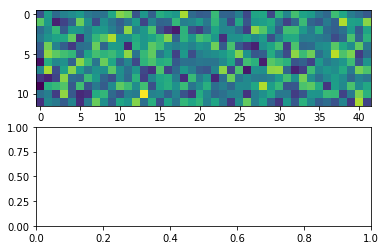

In [65]:
fig, (ax1, ax2) = plt.subplots(2,1)
c = ax1.imshow(np.std(alphas, axis=-1))
print(dir(ax1))
ax1.cax.colorbar(c)
c2 = ax2.imshow(np.mean(alphas, axis=-1))
ax2.cax.colorbar(c2)

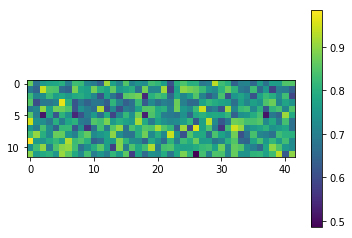

In [58]:
imshow(np.mean(alphas, axis=-1))
colorbar()